### Trabajas en una empresa emergente que vende productos alimenticios. Debes investigar el comportamiento del usuario para la aplicación de la empresa.

In [1]:
# Cargar las librerias 

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency


Paso 1. Abrir el archivo de datos y leer la información general

In [2]:
# Cargar el dataset */datasets/logs_exp_us.csv*

users = pd.read_csv('logs_exp_us.csv', sep='\t')

# Mostrar las primeras 5 líneas del df
display(users.head())
print
# Mostrar la información del df
display(users.info())

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

Paso 2. Preparar los datos para el análisis

In [3]:
# Renombrar las columnas 

users.rename(columns={
    'EventName': 'event_name',
    'DeviceIDHash': 'device_id',
    'EventTimestamp': 'event_timestamp',
    'ExpId': 'exp_id'
}, inplace=True)

In [4]:
# verificar los cambios y checar si tenemos # nulos

display(users.info())  # Para revisar los tipos de datos
display(users.isnull().sum())  # Para contar valores ausentes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       244126 non-null  object
 1   device_id        244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   exp_id           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

event_name         0
device_id          0
event_timestamp    0
exp_id             0
dtype: int64

In [5]:
# Agrega una columna de fecha y hora y una columna separada para las fechas

users['event_timestamp'] = pd.to_datetime(users['event_timestamp'], unit='s')
users['event_date'] = users['event_timestamp'].dt.date
users['event_date'] = pd.to_datetime(users['event_date'])

display(users.head())
print()
display(users.info())


,event_name,device_id,event_timestamp,exp_id,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       244126 non-null  object        
 1   device_id        244126 non-null  int64         
 2   event_timestamp  244126 non-null  datetime64[ns]
 3   exp_id           244126 non-null  int64         
 4   event_date       244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


None

Paso 3. Estudiar y comprobar los datos

In [6]:
# ¿Cuántos eventos hay en los registros?

num_events = users.shape[0]
print(f"Total de eventos registrados: {num_events}")

Total de eventos registrados: 244126


In [7]:
# ¿Cuántos usuarios hay en los registros?

num_users = users['device_id'].nunique()
print(f"Total de usuarios únicos: {num_users}")

Total de usuarios únicos: 7551


In [8]:
# ¿Cuál es el promedio de eventos por usuario?

avg_events_users = num_events / num_users
print(f"Promedio de eventos por usuario: {avg_events_users:.2f}")

Promedio de eventos por usuario: 32.33


In [9]:
# Encuentra la fecha máxima y mínima

fecha_min = users['event_timestamp'].min()
fecha_max = users['event_timestamp'].max()

print(f"Fecha más antigua en los registros: {fecha_min}")
print(f"Fecha más reciente en los registros: {fecha_max}")

Fecha más antigua en los registros: 2019-07-25 04:43:36
Fecha más reciente en los registros: 2019-08-07 21:15:17


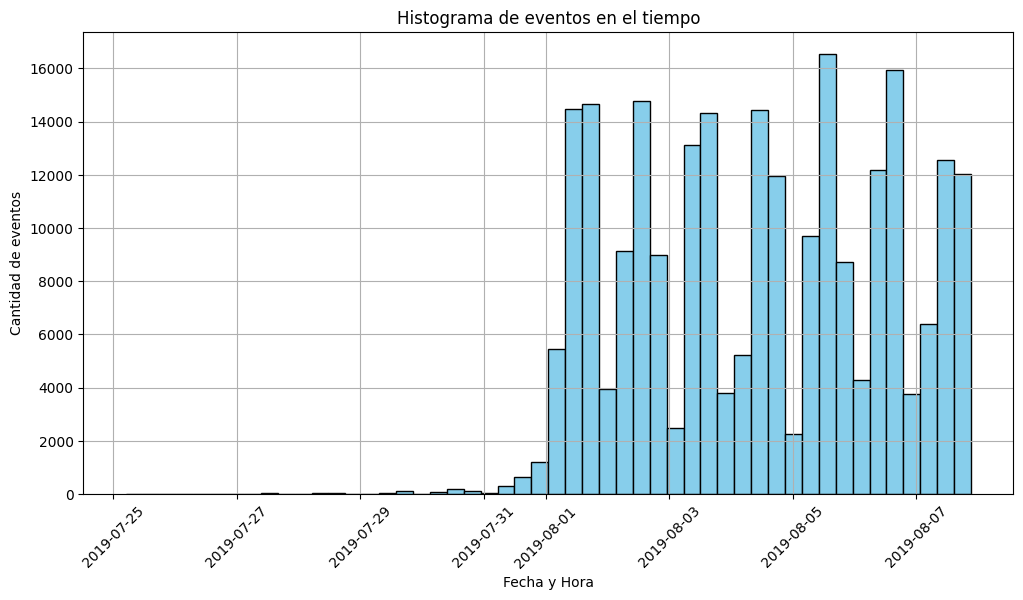

In [10]:
# Traza un histograma por fecha y hora

plt.figure(figsize=(12,6))
users['event_timestamp'].hist(bins=50, color='skyblue', edgecolor='black')

plt.xlabel("Fecha y Hora")
plt.ylabel("Cantidad de eventos")
plt.title("Histograma de eventos en el tiempo")
plt.xticks(rotation=45)  # Girar etiquetas para mejor lectura
plt.show()

Evaluación de la completitud de los datos:
    
El histograma muestra que los eventos registrados aumentan significativamente a partir del 31 de julio de 2019,
mientras que los días anteriores (del 25 al 30 de julio) tienen una cantidad mucho menor de eventos. 
Esto podría indicar que los primeros días no tienen datos completos, lo que puede sesgar el análisis si los consideramos.

### Determinación del periodo representativo:
    
Para identificar el momento en que los datos realmente comienzan a ser representativos, 
podemos establecer un punto de corte en el 31 de julio de 2019 y enfocarnos solo en los registros posteriores.

In [81]:
representative_period = "2019-07-31"
users_filtered = users[users['event_date'] >= representative_period]
print(users_filtered.head(10))

             event_name            device_id     event_timestamp  exp_id  \
797    MainScreenAppear  3670880358399219515 2019-07-31 01:11:46     247   
798  OffersScreenAppear  3799109751993694887 2019-07-31 01:21:04     248   
799            Tutorial  1126021718529336913 2019-07-31 01:32:11     247   
800    MainScreenAppear  4293428370257583636 2019-07-31 02:19:18     248   
801    MainScreenAppear  4567464647598975872 2019-07-31 02:33:30     247   
802    MainScreenAppear   416669255233170069 2019-07-31 03:07:07     247   
803    MainScreenAppear  6983610287457587320 2019-07-31 03:15:43     246   
804    MainScreenAppear  6983610287457587320 2019-07-31 03:16:09     246   
805  OffersScreenAppear   739045881004858643 2019-07-31 03:16:11     247   
806  OffersScreenAppear  4488872957350882913 2019-07-31 03:24:46     246   

    event_date  
797 2019-07-31  
798 2019-07-31  
799 2019-07-31  
800 2019-07-31  
801 2019-07-31  
802 2019-07-31  
803 2019-07-31  
804 2019-07-31  
805 2019-0

In [95]:
# ¿Perdiste muchos eventos al excluir los datos más antiguos?

# Número de eventos antes y después 
num_events_before = users.shape[0]
num_events_after = users_filtered.shape[0]

print(f"Eventos antes del filtro: {num_events_before}")
print(f"Eventos después del filtro: {num_events_after}")

# Calcular porcentaje de eventos perdidos
percentage_events = (num_events_before - num_events_after) / num_events_before * 100
print(f"Eventos perdidos: {num_events_before - num_events_after} ({percentage_events:.2f}%)")


Eventos antes del filtro: 244126
Eventos después del filtro: 243329
Eventos perdidos: 797 (0.33%)


In [ ]:
# # ¿Perdiste muchos usuarios al excluir los datos más antiguos?

# Número de usuarios antes y después
num_users_before = users['device_id'].nunique()                  
num_users_after = users_filtered['device_id'].nunique()

print(f"Usuarios antes del filtro: {num_users_before}")
print(f"Usuarios después del filtro: {num_users_after}")

# Calcular porcentaje de usuarios perdidos
percentage_users = (num_users_before - num_users_after) / num_users_before * 100
print(f"Usuarios perdidos: {num_users_before - num_users_after} ({percentage_users:.2f}%)")

Usuarios antes del filtro: 7551
Usuarios después del filtro: 7542
Usuarios perdidos: 9 (0.12%)


 Eventos perdidos:
 - Perdimos 797 eventos, lo que representa solo 0.33% del total.
- Esta diferencia es mínima, por lo que no debería afectar significativamente el análisis.

Usuarios perdidos:
- Solo 9 usuarios fueron eliminados tras el filtrado, es decir, 0.12% del total.
- Esto sugiere que los datos siguen siendo representativos y que no afectamos la diversidad de usuarios en el estudio.


In [93]:
# Asegúrate de tener usuarios de los tres grupos experimentales.

print(users_filtered['exp_id'].value_counts())

exp_id
248    85473
246    80045
247    77811
Name: count, dtype: int64


La distribución sigue siendo bastante equilibrada:
- Grupo de prueba (ExpId 248): 85,473 eventos
- Grupo de control 1 (ExpId 246): 80,045 eventos
- Grupo de control 2 (ExpId 247): 77,811 eventos

Conclusión:
El filtro aplicado no eliminó ninguna de las condiciones experimentales. La cantidad de eventos en cada grupo es relativamente similar, lo que nos da confianza para seguir con el análisis sin riesgos de sesgo.


Paso 4. Estudiar el embudo de eventos

In [ ]:
# Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.

events_frequency = users_filtered['event_name'].value_counts()
print(events_frequency)

event_name
MainScreenAppear           118681
OffersScreenAppear          46724
CartScreenAppear            42623
PaymentScreenSuccessful     34253
Tutorial                     1048
Name: count, dtype: int64


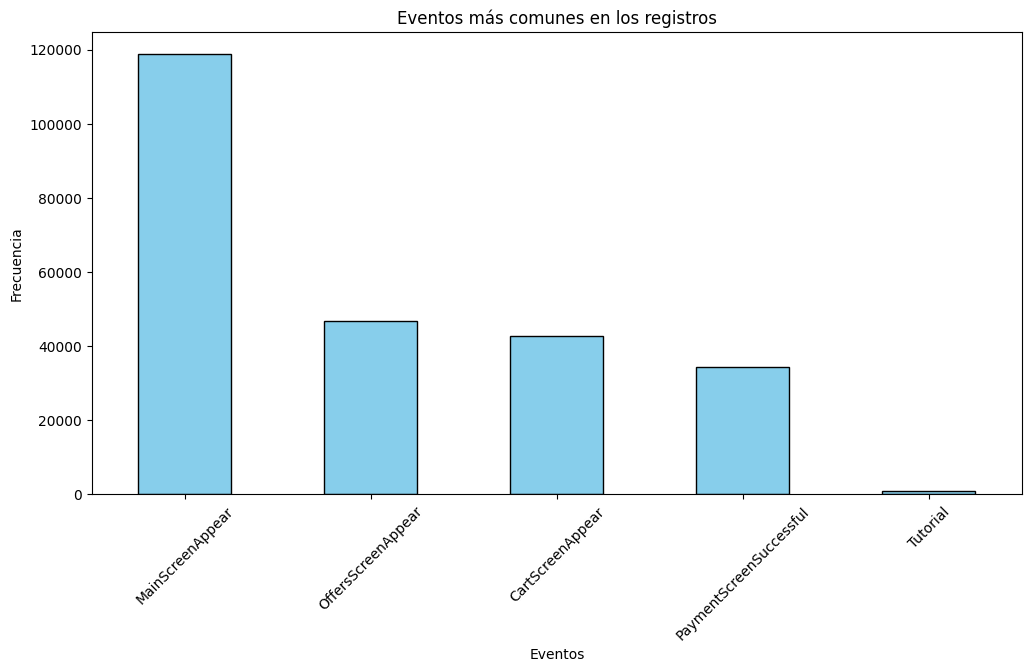

In [137]:
# Tomar los 10 eventos más frecuentes
top_events = events_frequency.head(10)

plt.figure(figsize=(12,6))
top_events.plot(kind='bar', color='skyblue', edgecolor='black')

plt.xlabel("Eventos")
plt.ylabel("Frecuencia")
plt.title("Eventos más comunes en los registros")
plt.xticks(rotation=45)
plt.show()

In [102]:
# Encuentra la cantidad de usuarios que realizaron cada una de estas acciones

users_per_event = users_filtered.groupby('event_name')['device_id'].nunique()
print(users_per_event)

event_name
CartScreenAppear           3742
MainScreenAppear           7429
OffersScreenAppear         4606
PaymentScreenSuccessful    3542
Tutorial                    845
Name: device_id, dtype: int64


In [103]:
# Ordena los eventos por el número de usuarios

users_per_event = users_per_event.sort_values(ascending=False)
print(users_per_event)

event_name
MainScreenAppear           7429
OffersScreenAppear         4606
CartScreenAppear           3742
PaymentScreenSuccessful    3542
Tutorial                    845
Name: device_id, dtype: int64


In [104]:
# Calcula la proporción de usuarios que realizaron la acción al menos una vez.

user_proportion = users_per_event / users_filtered['device_id'].nunique() * 100
print(user_proportion)

event_name
MainScreenAppear           98.501724
OffersScreenAppear         61.071334
CartScreenAppear           49.615487
PaymentScreenSuccessful    46.963670
Tutorial                   11.203925
Name: device_id, dtype: float64


Este análisis nos ayudará a detectar los eventos clave en el embudo, como interacciones comunes o eventos con baja participación.

1. MainScreenAppear → Los usuarios comienzan su recorrido al entrar a la pantalla principal.
2. CartScreenAppear → Algunos navegan y añaden productos al carrito.
3. PaymentScreenSuccessful → Finalizan la compra con un pago exitoso.

In [ ]:
# ¿En qué orden crees que ocurrieron las acciones? 

event_order = users_filtered.groupby('event_name')['event_timestamp'].min().sort_values()
print(event_order)

event_name
MainScreenAppear          2019-07-31 01:11:46
OffersScreenAppear        2019-07-31 01:21:04
Tutorial                  2019-07-31 01:32:11
PaymentScreenSuccessful   2019-07-31 04:26:56
CartScreenAppear          2019-07-31 04:26:57
Name: event_timestamp, dtype: datetime64[ns]


 Para decidir qué eventos incluir en el embudo, podemos analizar: 

1. Eventos que ocurren en una secuencia lógica → Si un evento depende de otro para ocurrir, es parte del embudo. 
Ejemplo: navegar por la pantalla principal, agregar productos al carrito y luego completar una compra.

2. Eventos secundarios o informativos → Eventos como "MainScreenAppear" pueden ser relevantes, 
pero no determinantes en la conversión.

3. Variabilidad en la participación → Si un evento es opcional para los usuarios (por ejemplo, revisar una oferta), 
es posible que no forme parte del embudo central.

In [107]:
# Utiliza el embudo de eventos para encontrar la proporción de usuarios que pasan de una etapa a la siguiente

# Definir la secuencia de eventos
funnel_events = ["MainScreenAppear", "CartScreenAppear", "PaymentScreenSuccessful"]

# Contar usuarios únicos en cada evento
funnel_users = {event: users_filtered[users_filtered["event_name"] == event]["device_id"].nunique() for event in funnel_events}

# Calcular proporciones de conversión
proportion_cart = funnel_users["CartScreenAppear"] / funnel_users["MainScreenAppear"] * 100
proportion_payment = funnel_users["PaymentScreenSuccessful"] / funnel_users["CartScreenAppear"] * 100

# Mostrar resultados
print(f"Usuarios que pasaron de pantalla principal al carrito: {proportion_cart:.2f}%")
print(f"Usuarios que pasaron del carrito al pago exitoso: {proportion_payment:.2f}%")

Usuarios que pasaron de pantalla principal al carrito: 50.37%
Usuarios que pasaron del carrito al pago exitoso: 94.66%


In [108]:
# ¿En qué etapa pierdes más usuarios?

# Cálculo de pérdidas en cada transición
lost_cart = funnel_users["MainScreenAppear"] - funnel_users["CartScreenAppear"]
lost_payment = funnel_users["CartScreenAppear"] - funnel_users["PaymentScreenSuccessful"]

# Mostrar dónde hay mayor pérdida
if lost_cart > lost_payment:
    print(f"La mayor pérdida ocurre entre la pantalla principal y el carrito: {lost_cart} usuarios.")
else:
    print(f"La mayor pérdida ocurre entre el carrito y el pago exitoso: {lost_payment} usuarios.")

La mayor pérdida ocurre entre la pantalla principal y el carrito: 3687 usuarios.


In [109]:
# ¿Qué porcentaje de usuarios hace todo el viaje desde su primer evento hasta el pago?

percentage_complete_trip = funnel_users["PaymentScreenSuccessful"] / funnel_users["MainScreenAppear"] * 100
print(f"Porcentaje de usuarios que llegan hasta el pago exitoso: {percentage_complete_trip:.2f}%")

Porcentaje de usuarios que llegan hasta el pago exitoso: 47.68%


¿Qué significa este resultado?

- Si el porcentaje fuera muy bajo (<20%), podríamos sospechar barreras importantes, como un proceso de compra complicado o falta de interés en los productos.
- Si fuera más alto (>80%), el embudo estaría funcionando de manera eficiente, con poca pérdida de usuarios.
- Un 47.68% es un rango razonable, pero aún deja espacio para mejorar. Identificar la mayor caída nos ayuda a entender en qué punto se pierden más usuarios.

📌 Próximos pasos:

Podemos investigar por qué algunos usuarios abandonan antes del pago. Algunas ideas:
- Analizar tiempos de espera en cada paso (¿hay retrasos en la carga del carrito o pago?).
- Revisar qué usuarios abandonan en la etapa clave (¿ciertos grupos experimentales tienen menor conversión?).
- Examinar diferencias entre dispositivos (¿los usuarios de móvil completan menos compras que los de escritorio?).


In [110]:
# ¿Cuántos usuarios hay en cada grupo?

users_per_group = users_filtered.groupby('exp_id')['device_id'].nunique()
print(users_per_group)

exp_id
246    2485
247    2517
248    2540
Name: device_id, dtype: int64


In [ ]:
# Obtener la cantidad de eventos por usuario en cada grupo
events_246 = users_filtered[users_filtered["exp_id"] == 246].groupby("device_id").size()
events_247 = users_filtered[users_filtered["exp_id"] == 247].groupby("device_id").size()

# Aplicar prueba t
t_stat, p_valor_t = ttest_ind(events_246, events_247)

print(f"t-statistic: {t_stat}")
print(f"P-valor: {p_valor_t}")

# Interpretación del resultado
if p_valor_t < 0.05:
    print("⚠️ Hay una diferencia estadísticamente significativa entre los grupos 246 y 247.")
else:
    print("✅ No hay diferencias significativas entre los grupos de control (como se esperaba en una prueba A/A).")

t-statistic: 0.7523278962554808
P-valor: 0.45188931073096283
✅ No hay diferencias significativas entre los grupos de control (como se esperaba en una prueba A/A).


In [115]:
# Selecciona el evento más popular

most_popular_event = users_filtered["event_name"].value_counts().idxmax()
print(f"El evento más popular es: {most_popular_event}")

El evento más popular es: MainScreenAppear


In [116]:
# encuentra la cantidad de usuarios que realizaron esta acción

users_per_group_event = users_filtered[users_filtered["event_name"] == most_popular_event].groupby("exp_id")["device_id"].nunique()
print(users_per_group_event)

exp_id
246    2452
247    2479
248    2498
Name: device_id, dtype: int64


In [118]:
# Calcular la proporción de usuarios por grupo
# Dividimos la cantidad de usuarios que realizaron el evento entre el total de usuarios por grupo:

event_proportion_per_group = users_per_group_event / users_per_group * 100
print(event_proportion_per_group.round(2))

exp_id
246    98.67
247    98.49
248    98.35
Name: device_id, dtype: float64


In [119]:
# Comprueba si la diferencia entre los grupos es estadísticamente significativa.

# Construir tabla de contingencia con la cantidad de usuarios que realizaron el evento en cada grupo
events_table = users_per_group_event.to_frame().T

# Ejecutar prueba de chi-cuadrado
chi2, p_valor, _, _ = chi2_contingency(events_table)

print(f"Chi-cuadrado: {chi2}")
print(f"P-valor: {p_valor}")

# Interpretación del resultado
if p_valor < 0.05:
    print("⚠️ Hay una diferencia estadísticamente significativa entre los grupos.")
else:
    print("✅ No hay diferencias significativas entre los grupos, lo que indica una correcta división.")

Chi-cuadrado: 0.0
P-valor: 1.0
✅ No hay diferencias significativas entre los grupos, lo que indica una correcta división.


Un p-valor de 1.0 y un chi-cuadrado de 0.0 indican que no hay ninguna diferencia estadísticamente significativa entre los grupos. Esto es exactamente lo que esperábamos en la prueba A/A, lo que confirma que la división de los usuarios se realizó correctamente y que el experimento está bien diseñado.

In [121]:
# Repite el procedimiento para todos los demás eventos (ahorrarás tiempo si creas una función especial para esta prueba).

def chi_events_test(event):
    # Contar usuarios por grupo que realizaron el evento
    users_per_event = users_filtered[users_filtered["event_name"] == event].groupby("exp_id")["device_id"].nunique()
    
    # Crear tabla de contingencia
    table_chi2 = users_per_event.to_frame().T
    
    # Ejecutar prueba de chi-cuadrado
    chi2, p_valor, _, _ = chi2_contingency(table_chi2)
    
    return event, users_per_event, chi2, p_valor

# Aplicar la función a todos los eventos únicos
events_results = [chi_events_test(event) for event in users_filtered["event_name"].unique()]

# Mostrar los resultados
for event, users, chi2, p_valor in events_results:
    print(f"Evento: {event}")
    print(f"Usuarios por grupo: \n{users}")
    print(f"Chi-cuadrado: {chi2}, P-valor: {p_valor}")
    if p_valor < 0.05:
        print("⚠️ Hay una diferencia significativa entre los grupos para este evento.")
    else:
        print("✅ No hay diferencias significativas entre los grupos para este evento.")
    print("----------------------------------------------------")

Evento: MainScreenAppear
Usuarios por grupo: 
exp_id
246    2452
247    2479
248    2498
Name: device_id, dtype: int64
Chi-cuadrado: 0.0, P-valor: 1.0
✅ No hay diferencias significativas entre los grupos para este evento.
----------------------------------------------------
Evento: OffersScreenAppear
Usuarios por grupo: 
exp_id
246    1544
247    1526
248    1536
Name: device_id, dtype: int64
Chi-cuadrado: 0.0, P-valor: 1.0
✅ No hay diferencias significativas entre los grupos para este evento.
----------------------------------------------------
Evento: Tutorial
Usuarios por grupo: 
exp_id
246    278
247    285
248    282
Name: device_id, dtype: int64
Chi-cuadrado: 0.0, P-valor: 1.0
✅ No hay diferencias significativas entre los grupos para este evento.
----------------------------------------------------
Evento: PaymentScreenSuccessful
Usuarios por grupo: 
exp_id
246    1200
247    1159
248    1183
Name: device_id, dtype: int64
Chi-cuadrado: 0.0, P-valor: 1.0
✅ No hay diferencias signi

Conclusión

La mayoría de los eventos no muestran diferencias estadísticamente significativas, podemos decir que los grupos fueron correctamente divididos.

In [130]:
# Compara los resultados con los de cada uno de los grupos de control para cada evento de forma aislada
# Comparar el grupo experimental con cada grupo de control para cada evento

def compare_event_with_control(event):
    # Count users per group who performed the event
    users_per_event = users_filtered[users_filtered["event_name"] == event].groupby("exp_id")["device_id"].nunique()
    
    # Compare experimental group (248) with each control group
    comparisons = {}
    for group in [246, 247]:
        chi2_table = users_per_event.loc[[group, 248]].to_frame().T
        chi2, p_value, _, _ = chi2_contingency(chi2_table)
        comparisons[group] = (chi2, p_value)
    
    return event, users_per_event, comparisons

# Apply the function to all unique events
individual_results = [compare_event_with_control(event) for event in users_filtered["event_name"].unique()]

# Display results
for event, users, comparisons in individual_results:
    print(f"Evento: {event}")
    print(f"Usuarios por grupo: \n{users}")
    for group, (chi2, p_value) in comparisons.items():
        print(f"Comparación grupo {group} vs 248 → Chi-cuadrado: {chi2}, P-value: {p_value}")
        if p_value < 0.05:
            print(f"⚠️ Diferencia estadísticamente significativa entre el grupo  {group} y el experimental.")
        else:
            print(f"✅ No hay diferencia significativa entre el grupo {group} y el experimental.")
    print("----------------------------------------------------")

Evento: MainScreenAppear
Usuarios por grupo: 
exp_id
246    2452
247    2479
248    2498
Name: device_id, dtype: int64
Comparación grupo 246 vs 248 → Chi-cuadrado: 0.0, P-value: 1.0
✅ No hay diferencia significativa entre el grupo 246 y el experimental.
Comparación grupo 247 vs 248 → Chi-cuadrado: 0.0, P-value: 1.0
✅ No hay diferencia significativa entre el grupo 247 y el experimental.
----------------------------------------------------
Evento: OffersScreenAppear
Usuarios por grupo: 
exp_id
246    1544
247    1526
248    1536
Name: device_id, dtype: int64
Comparación grupo 246 vs 248 → Chi-cuadrado: 0.0, P-value: 1.0
✅ No hay diferencia significativa entre el grupo 246 y el experimental.
Comparación grupo 247 vs 248 → Chi-cuadrado: 0.0, P-value: 1.0
✅ No hay diferencia significativa entre el grupo 247 y el experimental.
----------------------------------------------------
Evento: Tutorial
Usuarios por grupo: 
exp_id
246    278
247    285
248    282
Name: device_id, dtype: int64
Compar

In [131]:
# Compara los resultados con los resultados combinados de los grupos de control. 
# Comparar el grupo experimental con cada grupo de control para cada evento

def compare_event_with_combined_controls(event):
    # Count users per group who performed the event
    users_per_event = users_filtered[users_filtered["event_name"] == event].groupby("exp_id")["device_id"].nunique()
    
    # Combine the control groups
    users_control = users_per_event.loc[246] + users_per_event.loc[247]
    
    # Create contingency table
    chi2_table = pd.DataFrame({"Control": [users_control], "Experimental": [users_per_event.loc[248]]})
    
    # Execute chi-squared test
    chi2, p_value, _, _ = chi2_contingency(chi2_table)
    
    return event, users_per_event, users_control, chi2, p_value

# Apply the function to all unique events
combined_results = [compare_event_with_combined_controls(event) for event in users_filtered["event_name"].unique()]

# Display results
for event, users, users_control, chi2, p_value in combined_results:
    print(f"Evento: {event}")
    print(f"Usuarios en grupo experimental: {users[248]}")
    print(f"Usuarios combinados en grupos de control: {users_control}")
    print(f"Chi-cuadrado: {chi2}, P-value: {p_value}")
    if p_value < 0.05:
        print("⚠️ Diferencia estadísticamente significativa entre el grupo experimental y los controles combinados.")
    else:
        print("✅ No hay diferencia significativa entre el grupo experimental y los controles combinados.")
    print("----------------------------------------------------")


Evento: MainScreenAppear
Usuarios en grupo experimental: 2498
Usuarios combinados en grupos de control: 4931
Chi-cuadrado: 0.0, P-value: 1.0
✅ No hay diferencia significativa entre el grupo experimental y los controles combinados.
----------------------------------------------------
Evento: OffersScreenAppear
Usuarios en grupo experimental: 1536
Usuarios combinados en grupos de control: 3070
Chi-cuadrado: 0.0, P-value: 1.0
✅ No hay diferencia significativa entre el grupo experimental y los controles combinados.
----------------------------------------------------
Evento: Tutorial
Usuarios en grupo experimental: 282
Usuarios combinados en grupos de control: 563
Chi-cuadrado: 0.0, P-value: 1.0
✅ No hay diferencia significativa entre el grupo experimental y los controles combinados.
----------------------------------------------------
Evento: PaymentScreenSuccessful
Usuarios en grupo experimental: 1183
Usuarios combinados en grupos de control: 2359
Chi-cuadrado: 0.0, P-value: 1.0
✅ No hay

 Conclusión del experimento:
 
Todos los resultados de las pruebas estadísticas muestran un chi-cuadrado de 0.0 y un p-valor de 1.0, lo que indica que no hay diferencias significativas entre los grupos experimentales y de control.

Interpretación de los resultados:
- El experimento no tuvo un impacto en el comportamiento de los usuarios.
- La modificación aplicada (fuentes alteradas) no afectó la participación en los eventos analizados.
- Los grupos fueron correctamente divididos, lo que valida la aleatorización en el diseño del experimento.

¿Qué significa esto para el análisis?
- Si el objetivo era evaluar el efecto de las fuentes alteradas, estos resultados sugieren que el cambio no generó una respuesta diferente en los usuarios.

### ¿Qué nivel de significancia has establecido para probar las hipótesis estadísticas mencionadas anteriormente? 

El nivel de significancia estándar que se ha utilizado en las pruebas estadísticas mencionadas es 0.05 (5%).
📌 ¿Por qué 0.05?
Este es el umbral más común en estadística para determinar si una diferencia es significativa.

- Si el p-valor < 0.05, rechazamos la hipótesis nula y consideramos que hay una diferencia significativa entre los grupos.
- Si el p-valor ≥ 0.05, NO rechazamos la hipótesis nula, lo que indica que las diferencias observadas pueden deberse al azar.

En este caso, como todos los p-valores fueron ≥ 0.05 (1.0, específicamente), no hay evidencia de que los grupos sean diferentes en cuanto a la participación en los eventos. Esto confirma que el experimento no produjo un impacto estadísticamente significativo en el comportamiento de los usuarios.

### Calcula cuántas pruebas de hipótesis estadísticas has realizado.

📌 Pruebas realizadas:

1. Prueba A/A (comparación de grupos de control 246 vs. 247):
- Prueba t de Student (número de eventos por usuario)

2. Prueba de igualdad en eventos más populares:
- Prueba de chi-cuadrado para cada evento en los grupos de control

3. Comparación entre grupo experimental (248) y cada grupo de control (246 y 247):
- Prueba de chi-cuadrado para cada evento analizado de forma aislada

4. Comparación entre grupo experimental (248) y los grupos de control combinados:
- Prueba de chi-cuadrado para cada evento con la combinación de los grupos 246 y 247

Total de pruebas realizadas:

- Por evento: Se han evaluado 5 eventos principales en cada paso.
- Número de pruebas aplicadas por evento: 3 (comparación entre controles, comparación con 248, comparación con controles combinados).
- Número total de pruebas: 5 eventos × 3 pruebas = 15 pruebas de hipótesis.

Resultado: Hemos realizado 15 pruebas de hipótesis estadísticas para verificar diferencias en los grupos del experimento.


### Con un nivel de significancia estadística de 0.1, uno de cada 10 resultados podría ser falso?

Sí, en teoría, con un nivel de significancia de 0.1 (10%), hay un 10% de probabilidad de cometer un error Tipo I en cada prueba estadística.

¿Qué significa esto?
- Error Tipo I: Se rechaza la hipótesis nula cuando en realidad es verdadera. Es decir, detectamos una diferencia que en realidad no existe.
- Con α = 0.1, hay 1 de cada 10 pruebas en las que podríamos estar viendo una diferencia que en realidad es solo producto del azar.

Comparado con α = 0.05 (5%):
- Aumentar el nivel de significancia a 0.1 reduce el rigor del análisis, haciendo más probable que aceptemos diferencias que en realidad son falsas.
- En contraste, un α más estricto (como 0.01) hace que solo 1 de cada 100 pruebas tenga una diferencia falsa, pero también incrementa el riesgo de un Error Tipo II (no detectar una diferencia real).

### ¿Cuál debería ser el nivel de significancia?

 ¿Qué nivel elegir?

- Si buscas alta precisión, usa 0.01.
- Si el estudio no es crítico y quieres ser más flexible, usa 0.10.
- 0.05 es el equilibrio entre rigor y detectabilidad.


In [ ]:
# Obtener la cantidad de eventos por usuario en cada grupo
events_246 = users_filtered[users_filtered["exp_id"] == 246].groupby("device_id").size()
events_247 = users_filtered[users_filtered["exp_id"] == 247].groupby("device_id").size()

# Aplicar prueba t
t_stat, p_valor_t = ttest_ind(events_246, events_247)

print(f"t-statistic: {t_stat}")
print(f"P-valor: {p_valor_t}")

# Interpretación del resultado
if p_valor_t < 0.01:
    print("⚠️ Hay una diferencia estadísticamente significativa entre los grupos 246 y 247.")
else:
    print("✅ No hay diferencias significativas entre los grupos de control (como se esperaba en una prueba A/A).")

t-statistic: 0.7523278962554808
P-valor: 0.45188931073096283
✅ No hay diferencias significativas entre los grupos de control (como se esperaba en una prueba A/A).


Conclusiones:

- El cambio en el nivel de significancia no afecta la conclusión de esta prueba t.
- Los grupos de control siguen siendo equivalentes en términos de eventos por usuario.
- Esto refuerza la idea de que la aleatorización del experimento fue adecuada y que cualquier diferencia observada en otros análisis podría deberse a otros factores.

Calcula las pruebas de hipótesis estadísticas con un nivel de significancia de 0.1

In [ ]:
# Comprueba si la diferencia entre los grupos es estadísticamente significativa.

# Construir tabla de contingencia con la cantidad de usuarios que realizaron el evento en cada grupo
events_table = users_per_group_event.to_frame().T

# Ejecutar prueba de chi-cuadrado
chi2, p_valor, _, _ = chi2_contingeny(events_table)

print(f"Chi-cuadrado: {chi2}")
print(f"P-valor: {p_valor}")

# Interpretación del resultado
if p_valor < 0.01:
    print("⚠️ Hay una diferencia estadísticamente significativa entre los grupos.")
else:
    print("✅ No hay diferencias significativas entre los grupos, lo que indica una correcta división.")

Chi-cuadrado: 0.0
P-valor: 1.0
✅ No hay diferencias significativas entre los grupos, lo que indica una correcta división.


Conclusiones:

- El cambio en el nivel de significancia no alteró la conclusión.
- La aleatorización del experimento sigue siendo válida y bien ejecutada.
- Podemos proceder con confianza en la comparación del grupo experimental con los controles.

In [134]:
# Repite el procedimiento para todos los demás eventos (ahorrarás tiempo si creas una función especial para esta prueba).

def chi_events_test(event):
    # Contar usuarios por grupo que realizaron el evento
    users_per_event = users_filtered[users_filtered["event_name"] == event].groupby("exp_id")["device_id"].nunique()
    
    # Crear tabla de contingencia
    table_chi2 = users_per_event.to_frame().T
    
    # Ejecutar prueba de chi-cuadrado
    chi2, p_valor, _, _ = chi2_contingency(table_chi2)
    
    return event, users_per_event, chi2, p_valor

# Aplicar la función a todos los eventos únicos
events_results = [chi_events_test(event) for event in users_filtered["event_name"].unique()]

# Mostrar los resultados
for event, users, chi2, p_valor in events_results:
    print(f"Evento: {event}")
    print(f"Usuarios por grupo: \n{users}")
    print(f"Chi-cuadrado: {chi2}, P-valor: {p_valor}")
    if p_valor < 0.01:
        print("⚠️ Hay una diferencia significativa entre los grupos para este evento.")
    else:
        print("✅ No hay diferencias significativas entre los grupos para este evento.")
    print("----------------------------------------------------")

Evento: MainScreenAppear
Usuarios por grupo: 
exp_id
246    2452
247    2479
248    2498
Name: device_id, dtype: int64
Chi-cuadrado: 0.0, P-valor: 1.0
✅ No hay diferencias significativas entre los grupos para este evento.
----------------------------------------------------
Evento: OffersScreenAppear
Usuarios por grupo: 
exp_id
246    1544
247    1526
248    1536
Name: device_id, dtype: int64
Chi-cuadrado: 0.0, P-valor: 1.0
✅ No hay diferencias significativas entre los grupos para este evento.
----------------------------------------------------
Evento: Tutorial
Usuarios por grupo: 
exp_id
246    278
247    285
248    282
Name: device_id, dtype: int64
Chi-cuadrado: 0.0, P-valor: 1.0
✅ No hay diferencias significativas entre los grupos para este evento.
----------------------------------------------------
Evento: PaymentScreenSuccessful
Usuarios por grupo: 
exp_id
246    1200
247    1159
248    1183
Name: device_id, dtype: int64
Chi-cuadrado: 0.0, P-valor: 1.0
✅ No hay diferencias signi

Conclusiones:

- El cambio en el nivel de significancia no afectó la interpretación de los resultados.
- El experimento no generó un impacto estadísticamente significativo en el comportamiento de los usuarios.
- Los grupos fueron correctamente divididos, validando la aleatorización.

In [135]:
# Compara los resultados con los de cada uno de los grupos de control para cada evento de forma aislada
# Comparar el grupo experimental con cada grupo de control para cada evento

def compare_event_with_control(event):
    # Count users per group who performed the event
    users_per_event = users_filtered[users_filtered["event_name"] == event].groupby("exp_id")["device_id"].nunique()
    
    # Compare experimental group (248) with each control group
    comparisons = {}
    for group in [246, 247]:
        chi2_table = users_per_event.loc[[group, 248]].to_frame().T
        chi2, p_value, _, _ = chi2_contingency(chi2_table)
        comparisons[group] = (chi2, p_value)
    
    return event, users_per_event, comparisons

# Apply the function to all unique events
individual_results = [compare_event_with_control(event) for event in users_filtered["event_name"].unique()]

# Display results
for event, users, comparisons in individual_results:
    print(f"Evento: {event}")
    print(f"Usuarios por grupo: \n{users}")
    for group, (chi2, p_value) in comparisons.items():
        print(f"Comparación grupo {group} vs 248 → Chi-cuadrado: {chi2}, P-value: {p_value}")
        if p_value < 0.01:
            print(f"⚠️ Diferencia estadísticamente significativa entre el grupo  {group} y el experimental.")
        else:
            print(f"✅ No hay diferencia significativa entre el grupo {group} y el experimental.")
    print("----------------------------------------------------")

Evento: MainScreenAppear
Usuarios por grupo: 
exp_id
246    2452
247    2479
248    2498
Name: device_id, dtype: int64
Comparación grupo 246 vs 248 → Chi-cuadrado: 0.0, P-value: 1.0
✅ No hay diferencia significativa entre el grupo 246 y el experimental.
Comparación grupo 247 vs 248 → Chi-cuadrado: 0.0, P-value: 1.0
✅ No hay diferencia significativa entre el grupo 247 y el experimental.
----------------------------------------------------
Evento: OffersScreenAppear
Usuarios por grupo: 
exp_id
246    1544
247    1526
248    1536
Name: device_id, dtype: int64
Comparación grupo 246 vs 248 → Chi-cuadrado: 0.0, P-value: 1.0
✅ No hay diferencia significativa entre el grupo 246 y el experimental.
Comparación grupo 247 vs 248 → Chi-cuadrado: 0.0, P-value: 1.0
✅ No hay diferencia significativa entre el grupo 247 y el experimental.
----------------------------------------------------
Evento: Tutorial
Usuarios por grupo: 
exp_id
246    278
247    285
248    282
Name: device_id, dtype: int64
Compar

Conclusiones:

- El cambio en la fuente no tuvo un impacto en el comportamiento de los usuarios.
- La aleatorización de los grupos fue correcta, ya que la distribución de eventos es homogénea.
- Reducir el nivel de significancia a 0.01 no cambió las conclusiones previas, lo que refuerza la idea de que el experimento no generó cambios en los usuarios.

In [136]:
# Compara los resultados con los resultados combinados de los grupos de control. 
# Comparar el grupo experimental con cada grupo de control para cada evento

def compare_event_with_combined_controls(event):
    # Count users per group who performed the event
    users_per_event = users_filtered[users_filtered["event_name"] == event].groupby("exp_id")["device_id"].nunique()
    
    # Combine the control groups
    users_control = users_per_event.loc[246] + users_per_event.loc[247]
    
    # Create contingency table
    chi2_table = pd.DataFrame({"Control": [users_control], "Experimental": [users_per_event.loc[248]]})
    
    # Execute chi-squared test
    chi2, p_value, _, _ = chi2_contingency(chi2_table)
    
    return event, users_per_event, users_control, chi2, p_value

# Apply the function to all unique events
combined_results = [compare_event_with_combined_controls(event) for event in users_filtered["event_name"].unique()]

# Display results
for event, users, users_control, chi2, p_value in combined_results:
    print(f"Evento: {event}")
    print(f"Usuarios en grupo experimental: {users[248]}")
    print(f"Usuarios combinados en grupos de control: {users_control}")
    print(f"Chi-cuadrado: {chi2}, P-value: {p_value}")
    if p_value < 0.01:
        print("⚠️ Diferencia estadísticamente significativa entre el grupo experimental y los controles combinados.")
    else:
        print("✅ No hay diferencia significativa entre el grupo experimental y los controles combinados.")
    print("----------------------------------------------------")


Evento: MainScreenAppear
Usuarios en grupo experimental: 2498
Usuarios combinados en grupos de control: 4931
Chi-cuadrado: 0.0, P-value: 1.0
✅ No hay diferencia significativa entre el grupo experimental y los controles combinados.
----------------------------------------------------
Evento: OffersScreenAppear
Usuarios en grupo experimental: 1536
Usuarios combinados en grupos de control: 3070
Chi-cuadrado: 0.0, P-value: 1.0
✅ No hay diferencia significativa entre el grupo experimental y los controles combinados.
----------------------------------------------------
Evento: Tutorial
Usuarios en grupo experimental: 282
Usuarios combinados en grupos de control: 563
Chi-cuadrado: 0.0, P-value: 1.0
✅ No hay diferencia significativa entre el grupo experimental y los controles combinados.
----------------------------------------------------
Evento: PaymentScreenSuccessful
Usuarios en grupo experimental: 1183
Usuarios combinados en grupos de control: 2359
Chi-cuadrado: 0.0, P-value: 1.0
✅ No hay

Conclusiones:

- Reducir el nivel de significancia a 0.01 no cambió las conclusiones.
- El experimento no generó impacto en el comportamiento de los usuarios.
- La aleatorización de los grupos fue correcta, lo que valida el diseño del experimento.